In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from datasets import load_dataset

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
dataset_name = 'dataset_players_statistics'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

# Load data and split

In [3]:
train = pd.read_csv(out)
#train = train.drop(['game'], axis=1)
target = 'result'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
train

,game,bluetopgp,bluetopwr,bluetopkda,bluejunglegp,bluejunglewr,bluejunglekda,bluemidgp,bluemidwr,bluemidkda,...,redmidwr,redmidkda,redadcgp,redadcwr,redadckda,redsupportgp,redsupportwr,redsupportkda,result,Set
0,ESPORTSTMNT03/1632489,8,0.50,2.9,27,0.85,5.9,54,0.74,10.2,...,0.46,3.6,21,0.57,4.3,10,0.60,2.5,0,train
1,ESPORTSTMNT03/1632500,14,0.36,2.6,63,0.63,5.1,1,0.00,1.0,...,0.70,5.0,10,0.70,5.3,11,0.55,2.8,1,train
2,ESPORTSTMNT03/1632502,14,0.36,2.6,63,0.63,5.1,4,0.25,2.3,...,0.50,3.8,10,0.70,5.3,11,0.55,2.8,1,train
3,6909-9183,2,0.00,0.9,5,0.60,3.9,36,0.75,6.2,...,0.67,5.2,43,0.60,6.3,4,0.75,4.5,1,train
4,6909-9184,16,0.56,2.8,11,0.55,3.6,50,0.64,6.1,...,0.67,5.2,43,0.60,6.3,2,0.50,1.4,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,ESPORTSTMNT02/1726029,6,0.67,2.9,5,0.40,6.1,11,0.45,4.8,...,0.80,3.8,1,0.00,3.0,3,0.67,4.4,0,test
2836,ESPORTSTMNT02/1726064,5,0.80,4.0,1,1.00,12.0,3,0.67,6.0,...,0.33,1.9,19,0.47,3.7,4,0.75,2.3,0,test
2837,ESPORTSTMNT02/1726065,12,0.50,2.4,6,0.67,6.0,3,1.00,6.3,...,0.69,7.4,20,0.70,4.3,15,0.53,2.8,0,train
2838,ESPORTSTMNT02/1726067,5,0.60,2.6,4,0.50,3.0,5,0.60,5.0,...,0.45,4.8,12,0.67,5.0,11,0.73,4.3,1,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [4]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

game 2840
bluetopgp 56
bluetopwr 74
bluetopkda 115
bluejunglegp 48
bluejunglewr 73
bluejunglekda 131
bluemidgp 62
bluemidwr 78
bluemidkda 141
blueadcgp 67
blueadcwr 80
blueadckda 144
bluesupportgp 63
bluesupportwr 77
bluesupportkda 111
redtopgp 56
redtopwr 77
redtopkda 108
redjunglegp 49
redjunglewr 72
redjunglekda 125
redmidgp 64
redmidwr 73
redmidkda 142
redadcgp 65
redadcwr 80
redadckda 135
redsupportgp 63
redsupportwr 76
redsupportkda 110
result 2
Set 3


In [5]:
categorical_columns

['game',
 'bluetopgp',
 'bluetopwr',
 'bluetopkda',
 'bluejunglegp',
 'bluejunglewr',
 'bluejunglekda',
 'bluemidgp',
 'bluemidwr',
 'bluemidkda',
 'blueadcgp',
 'blueadcwr',
 'blueadckda',
 'bluesupportgp',
 'bluesupportwr',
 'bluesupportkda',
 'redtopgp',
 'redtopwr',
 'redtopkda',
 'redjunglegp',
 'redjunglewr',
 'redjunglekda',
 'redmidgp',
 'redmidwr',
 'redmidkda',
 'redadcgp',
 'redadcwr',
 'redadckda',
 'redsupportgp',
 'redsupportwr',
 'redsupportkda',
 'result',
 'Set']

In [6]:
categorical_dims

{'game': 2840,
 'bluetopgp': 56,
 'bluetopwr': 74,
 'bluetopkda': 115,
 'bluejunglegp': 48,
 'bluejunglewr': 73,
 'bluejunglekda': 131,
 'bluemidgp': 62,
 'bluemidwr': 78,
 'bluemidkda': 141,
 'blueadcgp': 67,
 'blueadcwr': 80,
 'blueadckda': 144,
 'bluesupportgp': 63,
 'bluesupportwr': 77,
 'bluesupportkda': 111,
 'redtopgp': 56,
 'redtopwr': 77,
 'redtopkda': 108,
 'redjunglegp': 49,
 'redjunglewr': 72,
 'redjunglekda': 125,
 'redmidgp': 64,
 'redmidwr': 73,
 'redmidkda': 142,
 'redadcgp': 65,
 'redadcwr': 80,
 'redadckda': 135,
 'redsupportgp': 63,
 'redsupportwr': 76,
 'redsupportkda': 110,
 'result': 2,
 'Set': 3}

In [7]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "lose"
train.loc[train[target]==1, target] = "win"

# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [9]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":10, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'sparsemax' # "sparsemax, entmax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [12]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=max_epochs , patience=50,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    save_history.append(clf.history["valid_accuracy"])
    
assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.85254 | train_accuracy: 0.52606 | valid_accuracy: 0.50903 |  0:00:00s
epoch 1  | loss: 0.73418 | train_accuracy: 0.51982 | valid_accuracy: 0.54152 |  0:00:00s
epoch 2  | loss: 0.7044  | train_accuracy: 0.54031 | valid_accuracy: 0.54152 |  0:00:00s
epoch 3  | loss: 0.68113 | train_accuracy: 0.54254 | valid_accuracy: 0.5343  |  0:00:00s
epoch 4  | loss: 0.66472 | train_accuracy: 0.55278 | valid_accuracy: 0.55596 |  0:00:01s
epoch 5  | loss: 0.66822 | train_accuracy: 0.58263 | valid_accuracy: 0.56679 |  0:00:01s
epoch 6  | loss: 0.65229 | train_accuracy: 0.59733 | valid_accuracy: 0.55596 |  0:00:01s
epoch 7  | loss: 0.6563  | train_accuracy: 0.6245  | valid_accuracy: 0.57401 |  0:00:01s
epoch 8  | loss: 0.62667 | train_accuracy: 0.62094 | valid_accuracy: 0.58845 |  0:00:02s
epoch 9  | loss: 0.625   | train_accuracy: 0.64098 | valid_accuracy: 0.63899 |  0:00:02s
epoch 10 | loss: 0.61081 | train_accuracy: 0.65702 | valid_accuracy: 0.66065 |  0:00:02s
epoch 11 | loss: 0.59

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.85254 | train_accuracy: 0.52606 | valid_accuracy: 0.50903 |  0:00:00s
epoch 1  | loss: 0.73418 | train_accuracy: 0.51982 | valid_accuracy: 0.54152 |  0:00:00s
epoch 2  | loss: 0.7044  | train_accuracy: 0.54031 | valid_accuracy: 0.54152 |  0:00:00s
epoch 3  | loss: 0.68113 | train_accuracy: 0.54254 | valid_accuracy: 0.5343  |  0:00:00s
epoch 4  | loss: 0.66472 | train_accuracy: 0.55278 | valid_accuracy: 0.55596 |  0:00:01s
epoch 5  | loss: 0.66822 | train_accuracy: 0.58263 | valid_accuracy: 0.56679 |  0:00:01s
epoch 6  | loss: 0.65229 | train_accuracy: 0.59733 | valid_accuracy: 0.55596 |  0:00:01s
epoch 7  | loss: 0.6563  | train_accuracy: 0.6245  | valid_accuracy: 0.57401 |  0:00:01s
epoch 8  | loss: 0.62667 | train_accuracy: 0.62094 | valid_accuracy: 0.58845 |  0:00:02s
epoch 9  | loss: 0.625   | train_accuracy: 0.64098 | valid_accuracy: 0.63899 |  0:00:02s
epoch 10 | loss: 0.61081 | train_accuracy: 0.65702 | valid_accuracy: 0.66065 |  0:00:02s
epoch 11 | loss: 0.59

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


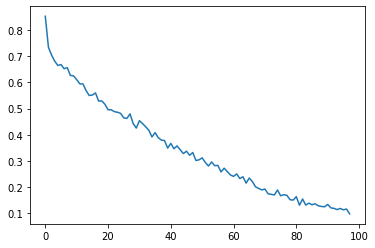

In [13]:
# plot losses
plt.plot(clf.history['loss'])

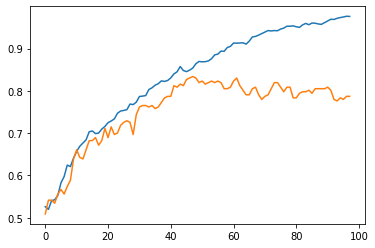

In [14]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

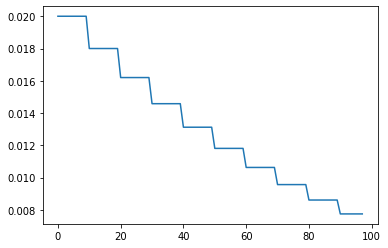

In [15]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [16]:
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_test ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])

preds_valid = clf.predict_proba(X_valid)
valid_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_valid ], y_pred=[0 if x < 0.5 else 1 for x in preds_valid[:,1]])
print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR dataset_players_statistics : 0.8339350180505415
FINAL TEST SCORE FOR dataset_players_statistics : 0.7547169811320755


In [17]:
# check that best weights are used
assert np.isclose(valid_acc, np.max(clf.history['valid_accuracy']), atol=1e-6)

In [18]:
clf.predict(X_test)

array(['lose', 'lose', 'win', 'lose', 'win', 'win', 'lose', 'win', 'lose',
       'win', 'win', 'win', 'lose', 'lose', 'win', 'lose', 'win', 'win',
       'lose', 'lose', 'win', 'win', 'win', 'win', 'lose', 'win', 'win',
       'lose', 'lose', 'win', 'lose', 'lose', 'win', 'lose', 'lose',
       'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'win',
       'lose', 'win', 'lose', 'lose', 'lose', 'win', 'lose', 'win',
       'lose', 'win', 'lose', 'lose', 'win', 'win', 'win', 'win', 'lose',
       'win', 'lose', 'win', 'win', 'lose', 'win', 'lose', 'win', 'win',
       'lose', 'win', 'lose', 'win', 'lose', 'lose', 'win', 'lose', 'win',
       'win', 'win', 'lose', 'win', 'lose', 'lose', 'lose', 'lose', 'win',
       'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'win', 'lose',
       'lose', 'lose', 'win', 'lose', 'lose', 'lose', 'win', 'win', 'win',
       'lose', 'lose', 'win', 'win', 'lose', 'win', 'win', 'win', 'win',
       'win', 'win', 'win', 'win', 'win', 'lose', 'lose',

# Save and load Model

In [19]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [20]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [21]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_test ], y_pred=[0 if x < 0.5 else 1 for x in loaded_preds[:,1]])
print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR dataset_players_statistics : 0.7547169811320755


In [22]:
assert(test_acc == loaded_test_acc)

In [23]:
loaded_clf.predict(X_test)

array(['lose', 'lose', 'win', 'lose', 'win', 'win', 'lose', 'win', 'lose',
       'win', 'win', 'win', 'lose', 'lose', 'win', 'lose', 'win', 'win',
       'lose', 'lose', 'win', 'win', 'win', 'win', 'lose', 'win', 'win',
       'lose', 'lose', 'win', 'lose', 'lose', 'win', 'lose', 'lose',
       'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'win',
       'lose', 'win', 'lose', 'lose', 'lose', 'win', 'lose', 'win',
       'lose', 'win', 'lose', 'lose', 'win', 'win', 'win', 'win', 'lose',
       'win', 'lose', 'win', 'win', 'lose', 'win', 'lose', 'win', 'win',
       'lose', 'win', 'lose', 'win', 'lose', 'lose', 'win', 'lose', 'win',
       'win', 'win', 'lose', 'win', 'lose', 'lose', 'lose', 'lose', 'win',
       'lose', 'lose', 'lose', 'lose', 'lose', 'lose', 'win', 'lose',
       'lose', 'lose', 'win', 'lose', 'lose', 'lose', 'win', 'win', 'win',
       'lose', 'lose', 'win', 'win', 'lose', 'win', 'win', 'win', 'win',
       'win', 'win', 'win', 'win', 'win', 'lose', 'lose',

# Global explainability : feat importance summing to 1

In [24]:
clf.feature_importances_.shape

(31,)

# Local explainability and masks

In [25]:
explain_matrix, masks = clf.explain(X_test)

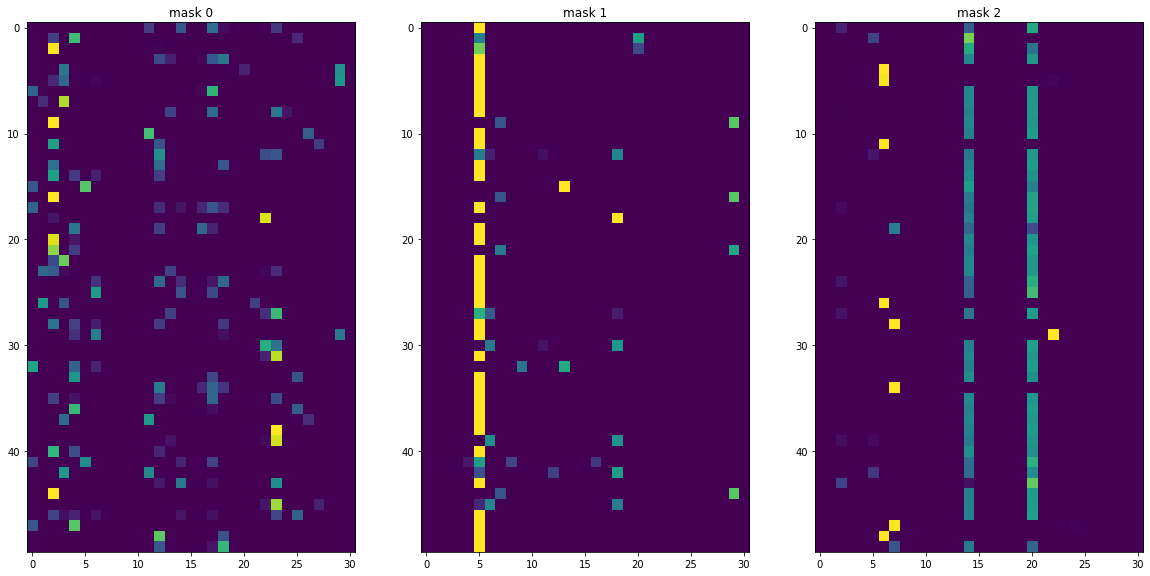

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [27]:
#pip install xgboost

In [28]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt 

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=200,
        verbose=10)



[0]	validation_0-logloss:0.63160
[10]	validation_0-logloss:0.34749


/opt/conda/envs/lightweight/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.25066
[30]	validation_0-logloss:0.21056
[40]	validation_0-logloss:0.18941
[50]	validation_0-logloss:0.17599
[60]	validation_0-logloss:0.16997
[70]	validation_0-logloss:0.17158
[80]	validation_0-logloss:0.17218
[90]	validation_0-logloss:0.17072
[100]	validation_0-logloss:0.17466
[110]	validation_0-logloss:0.17787
[120]	validation_0-logloss:0.17956
[130]	validation_0-logloss:0.17910
[140]	validation_0-logloss:0.18067
[150]	validation_0-logloss:0.18065
[160]	validation_0-logloss:0.17830
[170]	validation_0-logloss:0.17983
[180]	validation_0-logloss:0.17909
[190]	validation_0-logloss:0.18343
[200]	validation_0-logloss:0.18436
[210]	validation_0-logloss:0.18566
[220]	validation_0-logloss:0.18711
[230]	validation_0-logloss:0.18964
[240]	validation_0-logloss:0.19052
[250]	validation_0-logloss:0.19161
[260]	validation_0-logloss:0.19389
[263]	validation_0-logloss:0.19464


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=8, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, ...)

<BarContainer object of 31 artists>

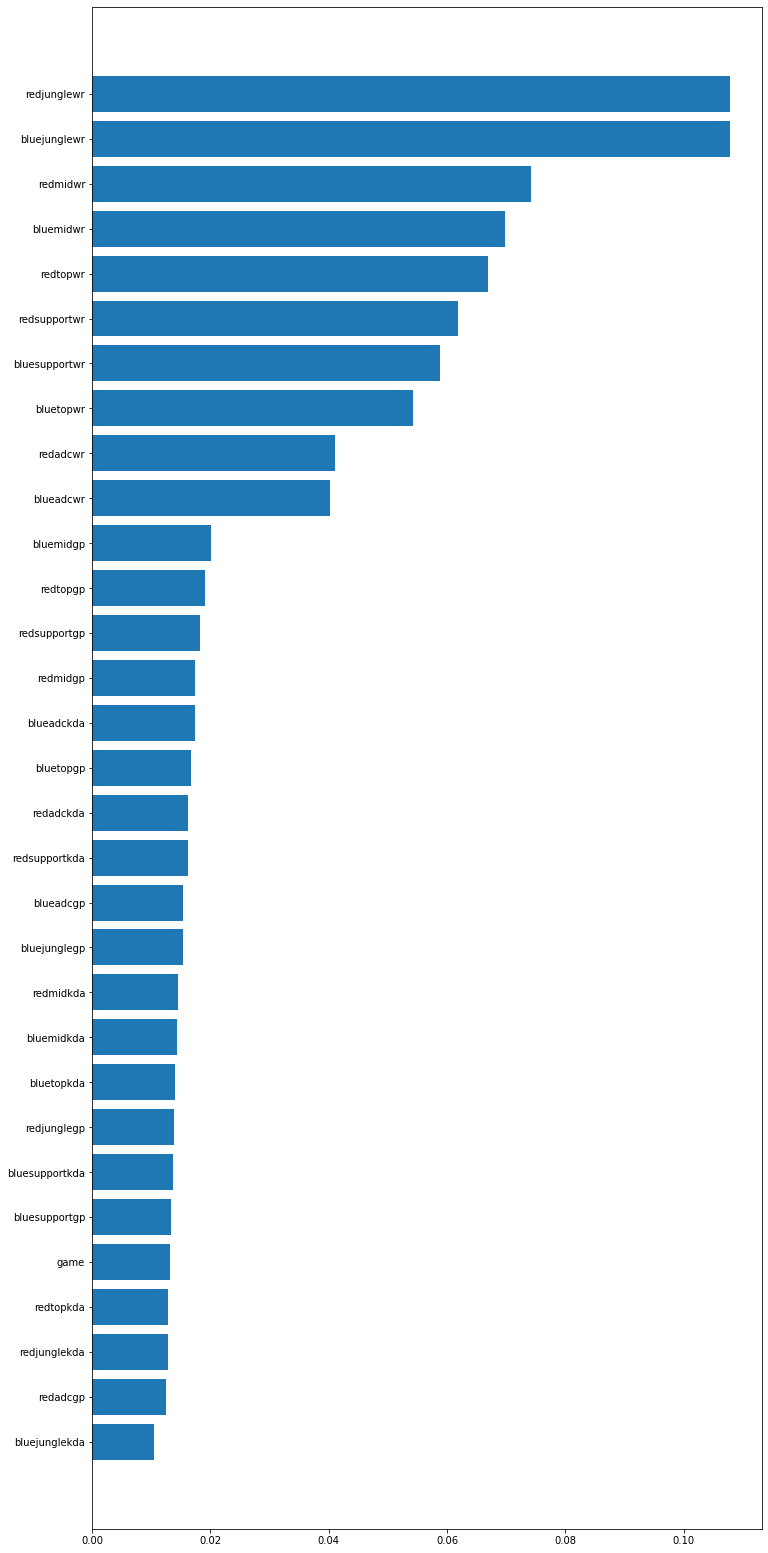

In [70]:
importances = clf_xgb.feature_importances_
features = list(train.columns[:-2])
importances_zip = zip(importances,features)
sorted_importances_zip = sorted(importances_zip)
fig, ax = plt.subplots(1,1, figsize=(12,28))
importances, features = zip(*sorted_importances_zip)
ax.barh(features, importances)

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_acc = accuracy_score(y_true= [0 if x =='lose' else 1 for x in y_valid ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_test ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics   
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, min_samples_split=10, max_features=7)
forest.fit(X_train, y_train)

preds = np.array(forest.predict_proba(X_valid))
valid_acc = accuracy_score(y_true= [0 if x =='lose' else 1 for x in y_valid ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(forest.predict_proba(X_test))
test_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_test ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)


In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=500)
logistic.fit(X_train, y_train)

preds = np.array(logistic.predict_proba(X_valid))
valid_acc = accuracy_score(y_true= [0 if x =='lose' else 1 for x in y_valid ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(logistic.predict_proba(X_test))
test_acc = accuracy_score(y_true=[0 if x =='lose' else 1 for x in y_test ], y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)